My own note about the words "probability" and "likelihood" in general (from https://www.statology.org/likelihood-vs-probability)

**Probability** refers to the chance that a particular outcome occurs based on the values of parameters in a model.

**Likelihood** refers to how well a sample provides support for particular values of a parameter in a model.

Let's consider a toy model. A circular hallway with 10 locations and some of them have doors. Our dog has a sensor attached that can sense if a door is near or not (with some probability of being correct). We want to take measurements to guess where our dog is. Our starting prior is that we have no idea where the dog is, so we have a uniform probability distribution.

We update our belief that the dog is at any given position with:

$$
\text{posterior} = \frac{\text{likelihood} \times \text{prior}}{\text{normalization}}
$$

The "posterior" is our new probability distribution across doors (or for a given door, it's the probability that the dog is at that door). The "prior" is our previous probability distribution across doors. We multiply this by the "likelihood" that the door sensor output is explained by the dog being at a given spot.

In the framework of the g-h filter, the "prior" is like the "prediction" and the "posterior" is like the "estimation".

In [21]:
import numpy as np
from filterpy.discrete_bayes import normalize

# Circular hallway where 1's represent locations with doors.
# We know what the hallway looks like.
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
# Our prior probability distribution for where the dog is.
prior = np.full(10, 0.1)
print(prior)
# This is p(z=1 | door) and also p(z=0 | not door)
# I was very confused about this before.
# See https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/issues/355#issuecomment-1151254146
z_prob = 0.75
# So let's say we make a measurement and we register a door.
z = 1
# Then for each spot considered individually, what is the likelihood
# that the dog is there?
# The 0th position has a door, so the likelihood that z = 1 is 0.75
# The 2nd position does not have a door, so the likelihood that z = 1 is 0.25
# So we just apply bayes to the whole array

likelihood = np.where(hallway == 1, z_prob, 1 - z_prob)
posterior = likelihood * prior
normalize(posterior)

print(posterior)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]


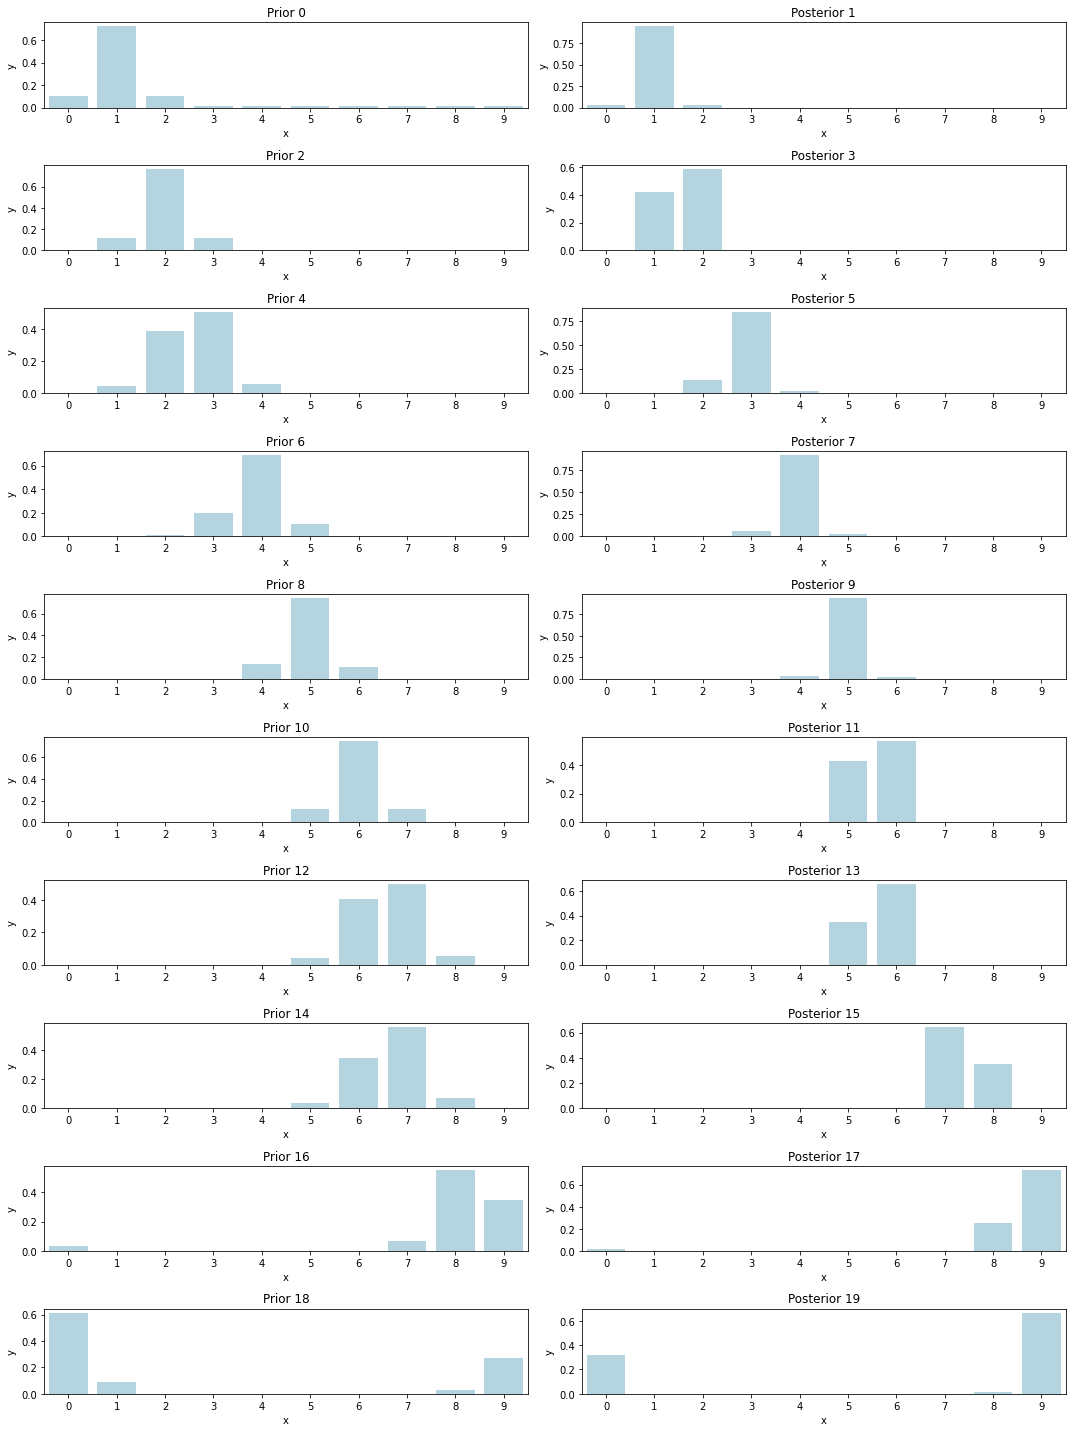

In [58]:
# Copying the train example but with my own "improvements" to the code
from typing import List
import random
from scipy.signal import convolve2d


class Train(object):

    def __init__(self, track_len: int, kernel: np.ndarray = np.ones(1), sensor_accuracy: float = 1.):
        """
        Args:
            kernel: 1D kernel describing the noise in the process model.
            sensor_accuracy: Probability that the sensor tells us the exact train position (otherwise the error is
                             equally distribitued across {-1, 1}).
        """
        assert track_len > 0 and isinstance(track_len, int), "track_len should be a positive integer"
        assert len(kernel) % 2 == 1, "Kernel should contain an odd number of elements"
        assert kernel.sum() == 1, "Kernel should sum to 1"
        assert np.all((kernel >= 0) & (kernel <= 1)), "All kernel elements should be in [0, 1]"
        assert sensor_accuracy >= 0 and sensor_accuracy <= 1, "sensor_accuracy should be in [0, 1]"
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance: int = 1):
        """ Move specified distance with some chance of error """
        assert isinstance(distance, int), "distance should be an integer"
        # Sample the kernel
        min_offset = -(len(self.kernel) - 1) / 2
        offset = np.random.choice(np.arange(min_offset, min_offset + len(self.kernel)), p=self.kernel)
        # Update the position
        self.pos += (distance + offset)
        return self.pos

    def sense(self):
        """ Sense the position with some probability of a one-off error """
        z = self.pos
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                z += 1
            else:
                z -= 1
        return int(z % self.track_len)


# I'll write my own filter without copying the code
def train_filter(
        prior: np.ndarray, ts_move_distance: List[int], kernel: np.ndarray, sensor_accuracy: float, do_print = False):
    """
    Args:
        prior: Array of floats representing our knowledge of where the train is. This also tells us the track length.
        ts_move_distance: How much we move the train by in each step (our simulation).
        kernel: See docstring for Train.
        sensor_accuracy: See docstring for Train.
    """
    assert len(kernel) % 2 == 1, "Kernel should contain an odd number of elements"
    assert kernel.sum() == 1, "Kernel should sum to 1"
    assert np.all((kernel >= 0) & (kernel <= 1)), "All kernel elements should be in [0, 1]"
    assert sensor_accuracy >= 0 and sensor_accuracy <= 1, "sensor_accuracy should be in [0, 1]"

    results = []

    xbar = prior  # use formal notation
    track_len = len(xbar)
    robot = Train(track_len, kernel, sensor_accuracy)

    x = xbar  # to star he loop off

    if do_print:
        print("Starting x:")
        print(x)

    for move_distance in ts_move_distance:
        # Move the robot
        robot.move(move_distance)

        # Do state propagation to get our prior
        xbar = convolve2d(np.roll(x, move_distance)[None], kernel[None], mode='same', boundary='wrap')[0]

        if do_print:
            print("Prior:")
            print(xbar)

        results.append(xbar)

        # Measure
        z = robot.sense()

        # Bayesian update to get posterior
        likelihood = np.zeros(track_len)
        likelihood[z] = sensor_accuracy
        likelihood[(z + 1) % track_len] = (1 - sensor_accuracy) / 2
        likelihood[(z - 1) % track_len] = (1 - sensor_accuracy) / 2
        x = normalize(likelihood * xbar)

        if do_print:
            print("Posterior:")
            print(x)

        results.append(x)

    return results
    

prior = np.array([.9] + [0.01]*9)
track = np.arange(len(prior))
ts = 10
results = train_filter(
    prior, ts_move_distance=[1]*ts, kernel = np.array([0.1, 0.8, 0.1]), sensor_accuracy=0.7, do_print=False)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax = plt.subplots(ts, 2, figsize=[15, 20])
ax = ax.flatten()
for i in range(len(ax)):
    df = pd.DataFrame(columns=['x', 'y'])
    df.x = track
    df.y = results[i]
    sns.barplot(x='x', y='y', data=df, ax=ax[i], color='lightblue')
    ax[i].set_title(f"Prior {i}" if i % 2 == 0 else f"Posterior {i}")

plt.tight_layout()